# 라이브러리 불러오기

In [1]:
# data visualization and manipulation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline 

# model selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

# DL libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

# CNN libraries
from keras.layers import Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random

# manipulating images and getting numpy arrays of pixel values of images.
import cv2                  
from tqdm import tqdm
import os                   
from random import shuffle  
from PIL import Image

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# 데이터 준비하기

In [2]:
DIR = "../input/flowers-recognition/flowers/flowers/"

folders = os.listdir(DIR)
folders

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

In [3]:
# 경로 설정
FLOWER_DAISY_DIR = '../input/flowers-recognition/flowers/flowers/daisy'
FLOWER_SUNFLOWER_DIR = '../input/flowers-recognition/flowers/flowers/sunflower'
FLOWER_TULIP_DIR = '../input/flowers-recognition/flowers/flowers/tulip'
FLOWER_DANDELION_DIR = '../input/flowers-recognition/flowers/flowers/dandelion'
FLOWER_ROSE_DIR = '../input/flowers-recognition/flowers/flowers/rose'

In [4]:
# 라벨링 함수
def assign_label(img, flower_type):
    return flower_type

In [5]:
# train data 생성 함수
def make_train_data(flower_type, DIR):
    for img in tqdm(os.listdir(DIR)):
        label = assign_label(img, flower_type) 
        path = os.path.join(DIR, img)
        
        try:
            img = cv2.imread(path, cv2.IMREAD_COLOR) # 이미지 읽기
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # size 변환
        
            Images.append(np.array(img)) # numpy로 저장
            Labels.append(str(label)) # 라벨 저장
        
        # jpg 파일이 아닌 경우 에러 핸들링
        except Exception as e:
            print("error image")
            print(e)

In [6]:
Images = [] # image
Labels = [] # label
IMG_SIZE = 150 # img size 설정

In [7]:
make_train_data('Daisy', FLOWER_DAISY_DIR)
make_train_data('Sunflower', FLOWER_SUNFLOWER_DIR)
make_train_data('Tulip', FLOWER_TULIP_DIR)
make_train_data('Rose', FLOWER_ROSE_DIR)
make_train_data('Dandelion', FLOWER_DANDELION_DIR)

  2%|▏         | 22/1055 [00:00<00:14, 71.15it/s]

error image
OpenCV(4.5.1) /tmp/pip-req-build-tk9iuyva/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

error image
OpenCV(4.5.1) /tmp/pip-req-build-tk9iuyva/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 64%|██████▍   | 677/1055 [00:10<00:05, 67.18it/s]

error image
OpenCV(4.5.1) /tmp/pip-req-build-tk9iuyva/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



100%|██████████| 1055/1055 [00:16<00:00, 63.43it/s]


In [8]:
print("Total image number : ", len(Images))

Total image number :  4323


# 시각화

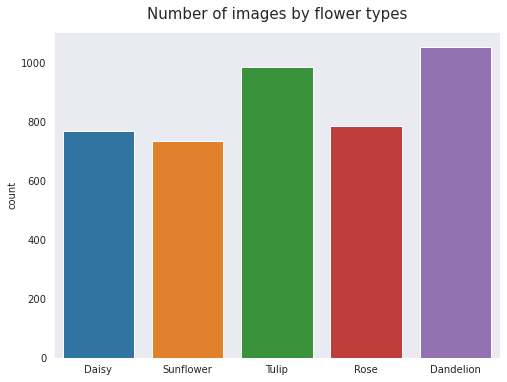

In [9]:
plt.figure(figsize = (8, 6))
sns.set_style('dark')
sns.countplot(Labels)
plt.title("Number of images by flower types", y = 1.02, size = 15)
plt.show()

- 비교적 고른 분포를 지님

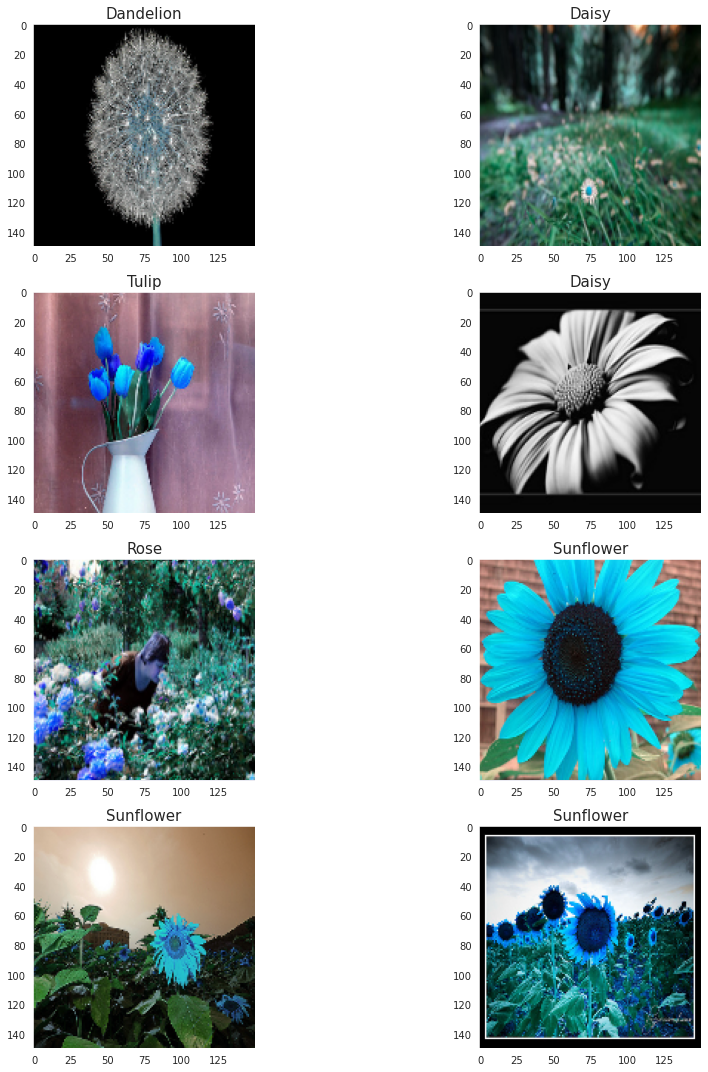

In [10]:
f, ax = plt.subplots(4, 2, figsize = (15, 15))

for i in range(4):
    for j in range (2):
        l = random.randint(0, len(Labels))
        ax[i, j].imshow(Images[l])
        ax[i, j].set_title(Labels[l], size = 15)
        
plt.tight_layout()

# 데이터 전처리 및 준비

In [11]:
# Label Encoding
le = LabelEncoder()
Y = le.fit_transform(Labels)
Y

array([0, 0, 0, ..., 1, 1, 1])

In [12]:
# One-hot Encoding
Y = to_categorical(Y, 5)
Y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [13]:
X = np.array(Images) / 255

In [14]:
X.shape, Y.shape

((4323, 150, 150, 3), (4323, 5))

In [15]:
# Splitting into Training and Validation Sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify = Y, random_state = 42)

In [16]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3458, 150, 150, 3), (3458, 5), (865, 150, 150, 3), (865, 5))

In [17]:
# Data Augmentation

datagen=ImageDataGenerator(
       
        rotation_range=10,  # 랜덤하게 10도 회전
        zoom_range = 0.1, # 랜덤하게 zoom
        width_shift_range=0.2,  # 랜덤하게 수평으로 shift
        height_shift_range=0.2,  # 랜덤하게 수직으로 shift
        horizontal_flip=True,  # 랜덤하게 수평으로 flip
        vertical_flip=False)  # 랜덤하게 수직으로 flip        

datagen.fit(X_train)

In [18]:
# LR 콜백함수
from keras.callbacks import ReduceLROnPlateau

reduceLR = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.1)

# 모델링

In [19]:
# Modelling CNN

model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation ='relu', input_shape = (IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation = "softmax"))

In [20]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0

In [22]:
batch_sizes = 128
epochs = 30

history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_sizes),
                              epochs=epochs, 
                              validation_data=(X_test,Y_test),
                              verbose = 1, 
                              steps_per_epoch=X_train.shape[0] // 128)

# history = model.fit(X_train, Y_train,
#           batch_size=batch_sizes,
#           epochs=epochs,
#           verbose=1, 
#           validation_data=(X_test, Y_test),
#           callbacks=[reduceLR])

Epoch 1/30
27/27 [==============================] - 23s 723ms/step - loss: 2.3691 - accuracy: 0.2525 - val_loss: 1.2653 - val_accuracy: 0.4254
Epoch 2/30
27/27 [==============================] - 18s 668ms/step - loss: 1.2992 - accuracy: 0.4340 - val_loss: 1.2061 - val_accuracy: 0.4705
Epoch 3/30
27/27 [==============================] - 18s 661ms/step - loss: 1.2335 - accuracy: 0.4658 - val_loss: 1.1357 - val_accuracy: 0.5110
Epoch 4/30
27/27 [==============================] - 19s 682ms/step - loss: 1.1312 - accuracy: 0.5216 - val_loss: 1.0302 - val_accuracy: 0.5908
Epoch 5/30
27/27 [==============================] - 18s 649ms/step - loss: 1.1928 - accuracy: 0.5143 - val_loss: 1.0400 - val_accuracy: 0.5919
Epoch 6/30
27/27 [==============================] - 18s 694ms/step - loss: 0.9968 - accuracy: 0.5983 - val_loss: 1.0453 - val_accuracy: 0.6023
Epoch 7/30
27/27 [==============================] - 18s 680ms/step - loss: 0.9519 - accuracy: 0.6197 - val_loss: 0.9798 - val_accuracy: 0.6197

# 모델 성능 확인하기

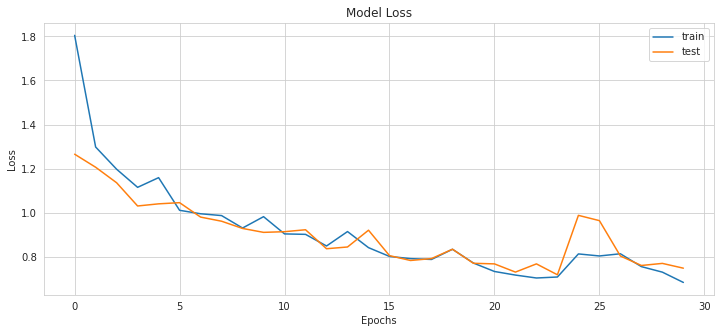

In [23]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

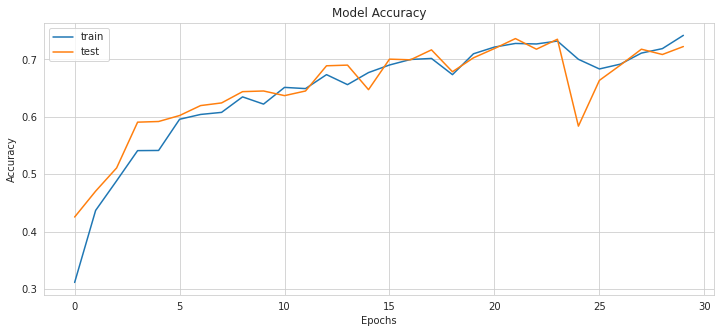

In [24]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# Transfer Learning - VGG16 

In [25]:
from tensorflow.keras.applications import VGG16

In [26]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [27]:
vgg16.trainable=False

In [28]:
model_vgg16 = Sequential([
    vgg16, 
    Flatten(),  
    Dense(5, activation='softmax')])

In [29]:
model_vgg16.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
batch_sizes = 32
epochs = 20

history = model_vgg16.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_sizes),
                              epochs=epochs, 
                              validation_data=(X_test,Y_test),
                              verbose = 1, 
                              steps_per_epoch=X_train.shape[0] // 32)

Epoch 1/20
108/108 [==============================] - 22s 191ms/step - loss: 1.1545 - accuracy: 0.5460 - val_loss: 0.7000 - val_accuracy: 0.7584
Epoch 2/20
108/108 [==============================] - 20s 185ms/step - loss: 0.6453 - accuracy: 0.7595 - val_loss: 0.6444 - val_accuracy: 0.7746
Epoch 3/20
108/108 [==============================] - 20s 180ms/step - loss: 0.5654 - accuracy: 0.7874 - val_loss: 0.6283 - val_accuracy: 0.7780
Epoch 4/20
108/108 [==============================] - 21s 189ms/step - loss: 0.5147 - accuracy: 0.8104 - val_loss: 0.6114 - val_accuracy: 0.7896
Epoch 5/20
108/108 [==============================] - 20s 187ms/step - loss: 0.4533 - accuracy: 0.8427 - val_loss: 0.5801 - val_accuracy: 0.7931
Epoch 6/20
108/108 [==============================] - 20s 189ms/step - loss: 0.4749 - accuracy: 0.8292 - val_loss: 0.5888 - val_accuracy: 0.7954
Epoch 7/20
108/108 [==============================] - 22s 204ms/step - loss: 0.4532 - accuracy: 0.8328 - val_loss: 0.5927 - val_ac

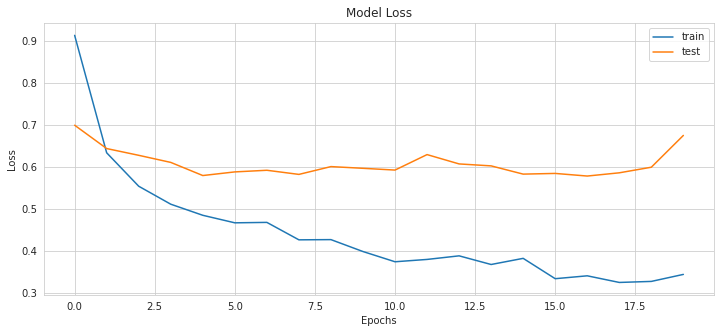

In [31]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

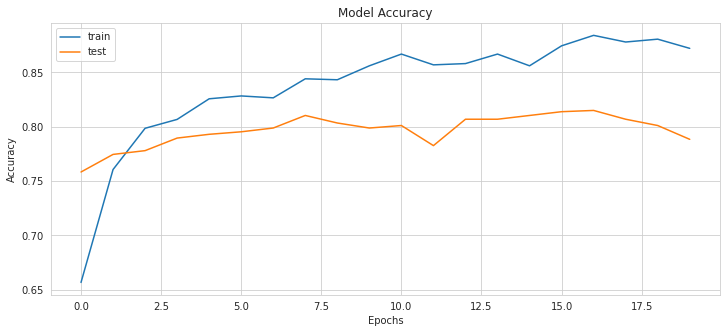

In [32]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [33]:
print("Test Loss :" , model_vgg16.evaluate(X_test, Y_test)[0])
print("Test Accuracy:" , model_vgg16.evaluate(X_test, Y_test)[1]*100 , "%")

28/28 [==============================] - 1s 35ms/step - loss: 0.6757 - accuracy: 0.7884
Test Loss : 0.6756792068481445
28/28 [==============================] - 1s 35ms/step - loss: 0.6757 - accuracy: 0.7884
Test Accuracy: 78.84393334388733 %


# Transfer Learning - VGG19

In [34]:
from keras.applications import VGG19

In [35]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

80142336/80134624 [==============================] - 1s 0us/step


In [36]:
vgg19.trainable=False

In [37]:
model_vgg19 = Sequential([
    vgg19, 
    Flatten(),  
    Dense(5, activation='softmax')])

In [38]:
model_vgg19.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
batch_sizes = 64
epochs = 15

history = model_vgg19.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_sizes),
                              epochs=epochs, 
                              validation_data=(X_test,Y_test),
                              verbose = 1, 
                              steps_per_epoch=X_train.shape[0] // 64)

Epoch 1/15
54/54 [==============================] - 23s 407ms/step - loss: 1.3009 - accuracy: 0.4726 - val_loss: 0.7491 - val_accuracy: 0.7260
Epoch 2/15
54/54 [==============================] - 22s 409ms/step - loss: 0.7126 - accuracy: 0.7501 - val_loss: 0.6597 - val_accuracy: 0.7607
Epoch 3/15
54/54 [==============================] - 23s 428ms/step - loss: 0.6114 - accuracy: 0.7802 - val_loss: 0.6364 - val_accuracy: 0.7711
Epoch 4/15
54/54 [==============================] - 22s 404ms/step - loss: 0.5924 - accuracy: 0.7873 - val_loss: 0.7412 - val_accuracy: 0.7329
Epoch 5/15
54/54 [==============================] - 22s 411ms/step - loss: 0.5966 - accuracy: 0.7765 - val_loss: 0.6190 - val_accuracy: 0.7711
Epoch 6/15
54/54 [==============================] - 23s 430ms/step - loss: 0.5503 - accuracy: 0.7993 - val_loss: 0.6555 - val_accuracy: 0.7711
Epoch 7/15
54/54 [==============================] - 22s 405ms/step - loss: 0.5016 - accuracy: 0.8224 - val_loss: 0.6155 - val_accuracy: 0.7815

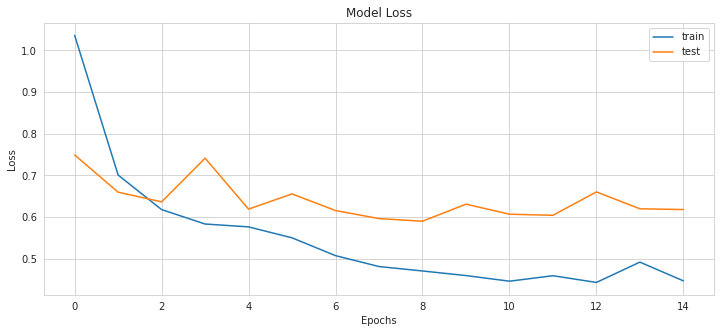

In [40]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

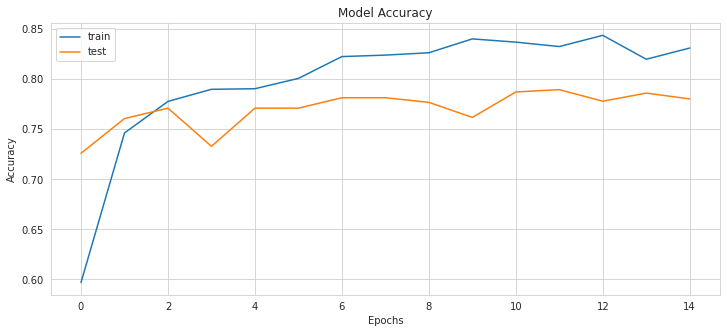

In [41]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [42]:
print("Test Loss :" , model_vgg19.evaluate(X_test, Y_test)[0])
print("Test Accuracy:" , model_vgg19.evaluate(X_test, Y_test)[1]*100 , "%")

28/28 [==============================] - 1s 43ms/step - loss: 0.6180 - accuracy: 0.7803
Test Loss : 0.6179514527320862
28/28 [==============================] - 1s 42ms/step - loss: 0.6180 - accuracy: 0.7803
Test Accuracy: 78.03468108177185 %
